In [16]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F
import time
import os
import torch.backends.cudnn as cudnn
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'                # GPU Number 
start_time = time.time()
batch_size = 128
learning_rate = 0.001
root_dir = 'drive/app/cifar10/'
default_directory = 'drive/app/torch/save_modelsvgg16'
classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

In [18]:
train_dataset = transforms.Compose([
    transforms.RandomCrop(32, padding=4),               
    transforms.RandomHorizontalFlip(),
    #transforms.Resize(size=(224, 224)),                 
    transforms.ToTensor(),                              
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467), 
                         std=(0.2471, 0.2436, 0.2616)) 
])

test_dataset = transforms.Compose([
    #transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),                              
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467), 
                         std=(0.2471, 0.2436, 0.2616))  
])

In [19]:
train_dataset = datasets.CIFAR10(root=root_dir,
                                 train=True,
                                 transform=train_dataset,
                                 download=True)

test_dataset = datasets.CIFAR10(root=root_dir,
                                train=False,
                                transform=test_dataset)

Files already downloaded and verified


In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,            
                                           num_workers=4)           

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,            
                                          num_workers=4)
n_total_step = len(train_loader)
print(n_total_step)

391


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(3, 3618, 1810)
(3618, 1810, 3)


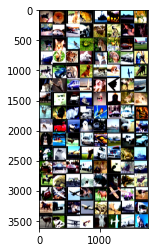

  dog   dog   dog  frog


In [21]:
def imshow(img):
    #Denormalize
    img = img / 2 + 0.5
    # torch.From tensor type to numpy.Convert to ndarray type
    print(type(img)) # <class 'torch.Tensor'>
    npimg = img.numpy()
    print(type(npimg))    
    #Convert shape from (RGB, vertical, horizontal) to (vertical, horizontal, RGB)
    print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    print(npimg.shape)
    #Display image
    plt.imshow(npimg)
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [24]:
model = models.vgg16(pretrained = True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
input_size = 224
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)

In [25]:
if torch.cuda.device_count() > 0:
    print("USE", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model).cuda()
    cudnn.benchmark = True
else:
    print("USE ONLY CPU!")


USE 1 GPUs!


In [27]:
def train(epoch):
    model.train()
    train_loss = 0 
    total = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)

        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()
        if batch_idx % 10 == 0:
            print('Epoch: {} | Batch_idx: {} |  Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
                  .format(epoch, batch_idx, train_loss / (batch_idx + 1), 100. * correct / total, correct, total))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        outputs = model(data)
        loss = criterion(outputs, target)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()
    print('# TEST : Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
          .format(test_loss / (batch_idx + 1), 100. * correct / total, correct, total))

In [ ]:

def save_checkpoint(directory, state, filename='latest.tar.gz'):

    if not os.path.exists(directory):
        os.makedirs(directory)

    model_filename = os.path.join(directory, filename)
    torch.save(state, model_filename)
    print("=> saving checkpoint")

def load_checkpoint(directory, filename='latest.tar.gz'):

    model_filename = os.path.join(directory, filename)
    if os.path.exists(model_filename):
        print("=> loading checkpoint")
        state = torch.load(model_filename)
        return state
    else:
        return None

start_epoch = 0

checkpoint = load_checkpoint(default_directory)
if not checkpoint:
    pass
else:
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

for epoch in range(start_epoch, 165):

    if epoch < 80:
        lr = learning_rate
    elif epoch < 120:
        lr = learning_rate * 0.1
    else:
        lr = learning_rate * 0.01
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    train(epoch)
    save_checkpoint(default_directory, {
        'epoch': epoch,
        'model': model,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    })
    test()  

now = time.gmtime(time.time() - start_time)
print('{} hours {} mins {} secs for training'.format(now.tm_hour, now.tm_min, now.tm_sec))

Epoch: 0 | Batch_idx: 0 |  Loss: (2.3665) | Acc: (10.16%) (13/128)
Epoch: 0 | Batch_idx: 10 |  Loss: (2.1761) | Acc: (21.95%) (309/1408)
Epoch: 0 | Batch_idx: 20 |  Loss: (1.9159) | Acc: (33.56%) (902/2688)
Epoch: 0 | Batch_idx: 30 |  Loss: (1.6279) | Acc: (43.75%) (1736/3968)
Epoch: 0 | Batch_idx: 40 |  Loss: (1.4340) | Acc: (50.72%) (2662/5248)
Epoch: 0 | Batch_idx: 50 |  Loss: (1.2948) | Acc: (55.44%) (3619/6528)
Epoch: 0 | Batch_idx: 60 |  Loss: (1.2001) | Acc: (58.56%) (4572/7808)
Epoch: 0 | Batch_idx: 70 |  Loss: (1.1168) | Acc: (61.51%) (5590/9088)
Epoch: 0 | Batch_idx: 80 |  Loss: (1.0549) | Acc: (63.56%) (6590/10368)
Epoch: 0 | Batch_idx: 90 |  Loss: (1.0010) | Acc: (65.29%) (7605/11648)
Epoch: 0 | Batch_idx: 100 |  Loss: (0.9581) | Acc: (66.89%) (8648/12928)
Epoch: 0 | Batch_idx: 110 |  Loss: (0.9185) | Acc: (68.25%) (9697/14208)
Epoch: 0 | Batch_idx: 120 |  Loss: (0.8819) | Acc: (69.49%) (10762/15488)
Epoch: 0 | Batch_idx: 130 |  Loss: (0.8543) | Acc: (70.45%) (11813/16768)
